In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.optimize import curve_fit

In [2]:
a, a_err = 3.1304347826086867e-06, 3.1304347826086867e-06
resolution, resolution_err = 0.018835915624440338, 0.00012187430782578249
c = 360/25600

## Data

In [3]:
data = pd.read_csv('./data/known.csv')

data['x'] *= a
data['theta'] *= c

x = np.sort(data['x'].unique())
theta = np.sort(data['theta'].unique())  # in degrees

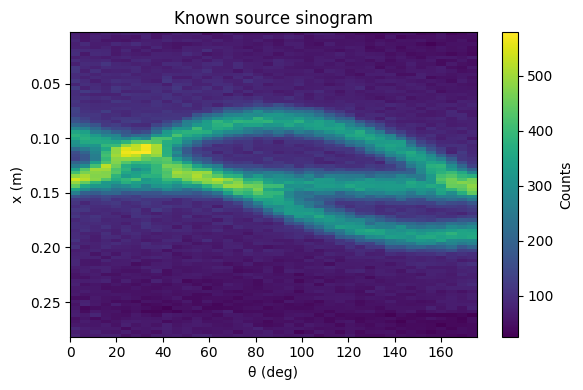

In [4]:
# 2. Pivot into sinogram array (shape: len(x) × len(theta))
sinogram_df = data.pivot(
    index='x',
    columns='theta',
    values='coincidences'
)
sinogram = sinogram_df.loc[x, theta].values
sinogram = np.roll(sinogram, -7, axis=0)

# 3. Display the sinogram
plt.figure(figsize=(6, 4))
plt.imshow(
    sinogram,
    aspect='auto',
    extent=[
        theta.min(), theta.max(),
        x.max(), x.min()
    ]
)
plt.xlabel("θ (deg)")
plt.ylabel("x (m)")
plt.title("Known source sinogram")
plt.colorbar(label="Counts")
plt.tight_layout()

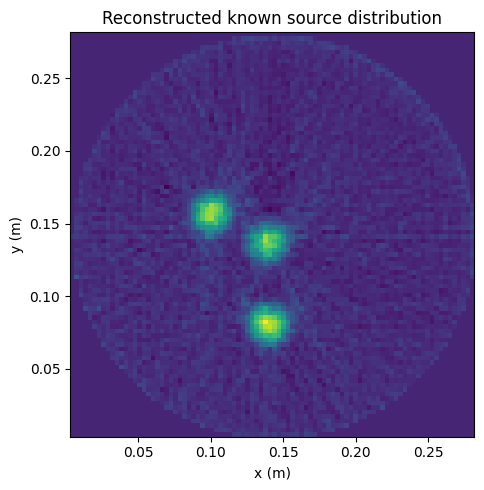

In [5]:
# 4. Perform filtered back‐projection (inverse Radon transform)
reconstruction = iradon(sinogram, theta=theta)

# 5. Display the reconstruction

fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(
    reconstruction,
    extent=[x.min(), x.max(), x.min(), x.max()]
)

ax.set_title('Reconstructed known source distribution')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

plt.tight_layout()

In [6]:
def gaussian2d(xdata, A, mu_x, mu_y, sigma, C):
    return A * np.exp(-((xdata[0] - mu_x) ** 2 + (xdata[1] - mu_y) ** 2) / (2 * sigma ** 2)) + C

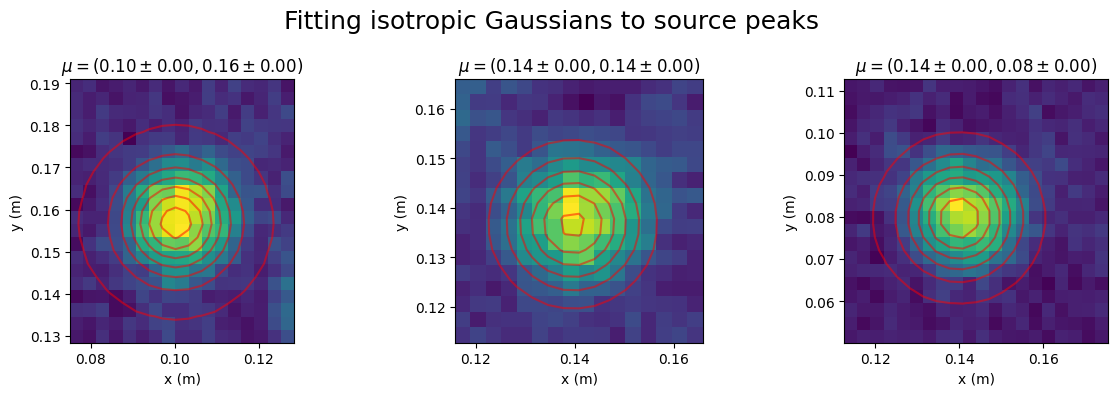

In [11]:
sources = [(23, 40, 30, 50), (36, 52, 38, 55), (35, 55, 55, 75)]
fig, axs = plt.subplots(1, len(sources), figsize=(4 * len(sources), 4))

positions = []
position_errs = []
for (x0, x1, y0, y1), ax in zip(sources, axs):

    # Plot reconstruction

    peak = reconstruction[y0:y1, x0:x1]

    ax.imshow(
        peak,
        extent=[x[x0], x[x1], x[90 - y1], x[90 - y0]]
    )
    ax.set_title('Source')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')

    # Fit gaussian

    coord_x, coord_y = np.meshgrid(x[x0 : x1], x[90 - y0 - 1: 90 - y1 - 1: -1])
    coord_z = (peak - peak.min())/peak.max()

    params_0 = [coord_z.max() - coord_z.min(), coord_x.min(), coord_y.min(), 0.03, coord_z.min()]
    params, params_cov = curve_fit(
        gaussian2d,
        (coord_x.ravel(), coord_y.ravel()),
        coord_z.ravel(),
        p0=params_0, 
        sigma = np.ones_like(coord_z).ravel(), 
        absolute_sigma=True
    )
    params_err = np.sqrt(np.diag(params_cov))
    
    positions.append((params[1], params[2]))
    position_errs.append((params_err[1], params_err[2]))

    # Plot contour

    ax.contour(
        coord_x, coord_y, 
        gaussian2d((coord_x, coord_y), *params), 
        colors='r', 
        alpha=0.5
    )
    ax.set_title(f'$\mu=({params[1]:.2f}\pm{params_err[1]:.2f}, {params[2]:.2f}\pm{params_err[1]:.2f})$')
    ax.set_aspect('equal')

fig.suptitle('Fitting isotropic Gaussians to source peaks', fontsize=18)
plt.tight_layout()

In [12]:
positions = np.array(positions)
position_errs = np.array(position_errs)

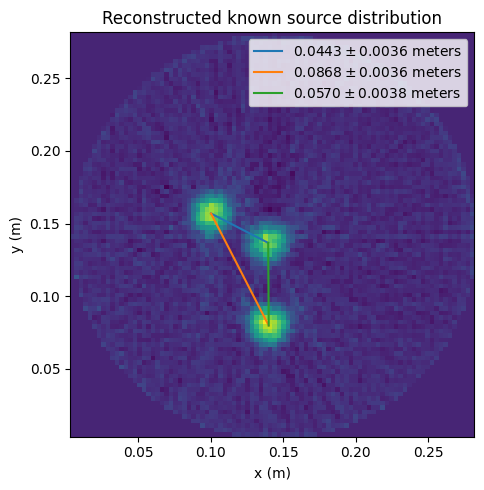

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(
    reconstruction,
    extent=[x.min(), x.max(), x.min(), x.max()]
)

for i in range(len(positions)):
    for j in range(i+1, len(positions)):
        r1, r2 = positions[i], positions[j]
        r1_err, r2_err = position_errs[i], position_errs[j]
        
        dr = r2 - r1
        d = np.linalg.norm(dr)
        J = np.hstack((-dr/d, dr/d))
        
        var = np.sum((J[:2]*r1_err)**2) + np.sum((J[2:]*r2_err)**2)
        d_err = np.sqrt(var)
        
        ax.plot(positions[(i, j), 0], positions[(i, j), 1], label=f'${d:.4f} \pm {d_err:.4f}$ meters')
        
ax.set_title('Reconstructed known source distribution')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.legend()

plt.tight_layout()